In [3]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kimgeonyu","key":"bfbdcd7b31bc168eddfae4e56bc4590e"}'}

In [8]:
# #json 파일 이동시키기.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 22.9MB/s]


In [10]:
!unzip /content/titanic.zip

Archive:  /content/titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [11]:
!ls

gender_submission.csv  sample_data  titanic.zip
kaggle.json	       test.csv     train.csv


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#요소들의 갯수를 쉽고 빠르게 계산 가능하다.
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
#선형 판별 분석(Linear Discriminant Analysis, LDA)을 수행-> 이게 무슨 말이지.
#: 입력데이터를 제일 잘 구분할 수 있는 경계를 만든다.
#-> 와닿지가 않네;
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
#다중퍼셉트론
from sklearn.neural_network import MLPClassifier
#서포트 벡터 분류기
from sklearn.svm import SVC
# GridSearchCV : 가능한 모든 하이퍼파라미터 조합에 대해 모델을 학습하고 검증하여 최적의 조합을 찾아냄
# cross_val_score : 모델 평가할 때 쓰는거
#StratifiedKFold : 모델의 일반적인 성능을 평가하는데 사용.
# learning_curve: 학습 곡선을 만드는데 사용.
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
sns.set(style="white", context="notebook", palette="deep")


In [13]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
IDtest = test["PassengerId"] #이거 왜 하는지 모르겠어.

In [14]:
def detect_outliers(df, n, features):
  outlier_indices = []

  for col in features:
    #데이터 분포에서 25프로.
    Q1 = np.percentile(df[col], 25)
    Q3= np.percentile(df[col], 75)
    IQR = Q3- Q1

    #이거 통계학적으로 정해놓은?거 같은데
    #예전에 배운듯...?
    outlier_step = 1.5 *IQR

    outlier_list_col = df[(df[col]<Q1-outlier_step) | (df[col] > Q3 + outlier_step)].index

    outlier_indices.extend(outlier_list_col)
  
  #딕셔너리 형태로 나옴.
  #key, value
  #기준치보다 더 많이 나온 key값을 알아내는거.
  outlier_indices = Counter(outlier_indices)
  multiple_outliers = list(k for k,v in outlier_indices.items() if v > n)

  return multiple_outliers

#정리하면 각 열마다 이상치가 있는 인덱스를 outlier_indices에 넣은 다음에
#그 인덱스가 기준치 이상이면 multiple_outliers에 넣는다.
Outliers_to_drop = detect_outliers(train, 2, ["Age", "SibSp", "Parch", "Fare"])

In [15]:
Outliers_to_drop

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

In [16]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [17]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [18]:
train_len = len(train)
#objs : 병합할거, axis=0 : 행으로 합치기, reset_index : 기존의 index 제거하고 새로운 인덱스로.
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [19]:
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [20]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [21]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [22]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [23]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


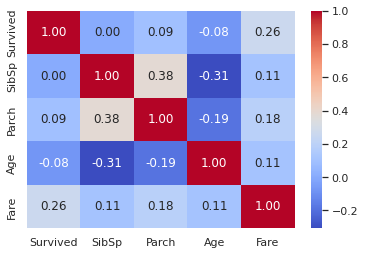

In [24]:
#"annot" 매개 변수는 히트맵의 각 셀에 상관 계수를 보여주기 위해 "True"로 
#fmt" 매개 변수는 계수를 소수점 둘째 자리까지 형식화
g = sns.heatmap(train[["Survived", "SibSp", "Parch", "Age", "Fare"]].corr(), annot=True, fmt=".2f", cmap="coolwarm")

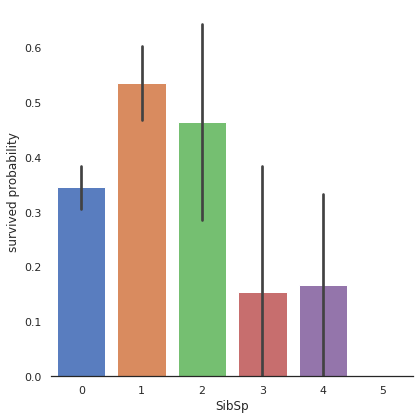

In [25]:
g = sns.catplot(x="SibSp",y="Survived",data=train,kind="bar", height = 6 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survived probability")

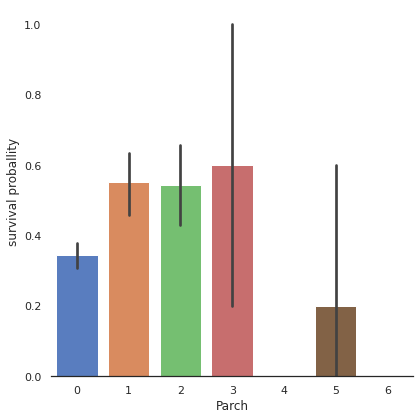

In [26]:
g = sns.catplot(x= "Parch", y="Survived", data = train, kind="bar", height=6,palette = "muted")
g.despine(left=True)
g =g.set_ylabels("survival proballity")

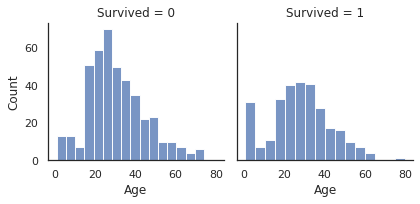

In [27]:
g = sns.FacetGrid(train,col="Survived" )
g = g.map(sns.histplot, "Age")

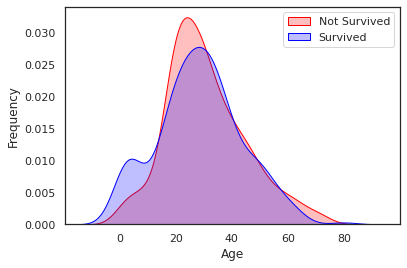

In [28]:
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())],
                color = "Red", fill = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())],
                ax = g, color = "Blue", fill = True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", "Survived"])

In [29]:
dataset["Fare"].isnull().sum()

1

In [30]:
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())


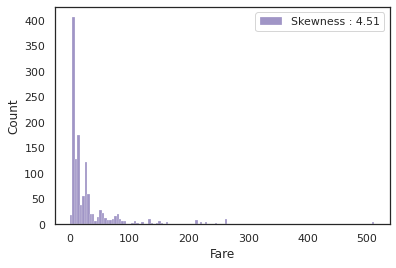

In [31]:
g = sns.histplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

In [32]:
dataset["Fare"] = dataset["Fare"].map(lambda i:np.log(i) if i >0 else 0)

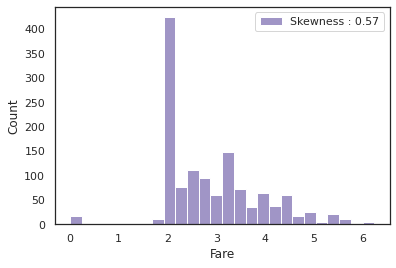

In [33]:
g = sns.histplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

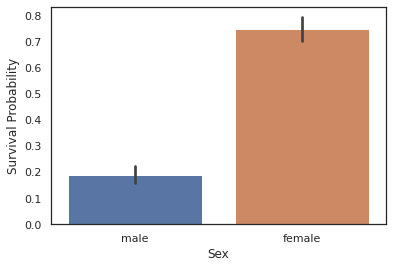

In [34]:
g = sns.barplot(x="Sex", y= "Survived", data = train)
g = g.set_ylabel("Survival Probability")

In [35]:
train[["Sex", "Survived"]].groupby("Sex").mean()

,Survived
Sex,
female,0.747573
male,0.190559


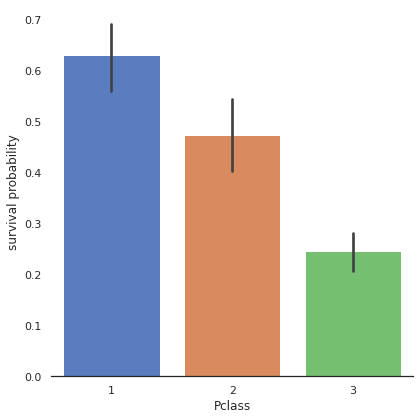

In [36]:
g = sns.catplot(x="Pclass", y="Survived", data= train, kind="bar", height=6, palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

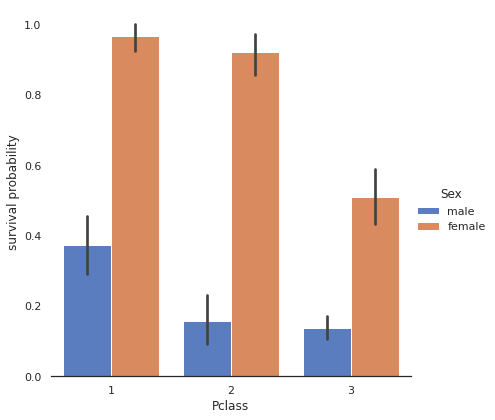

In [37]:
g = sns.catplot(x="Pclass", y="Survived", hue = "Sex", data = train, height=6, kind='bar', palette="muted")
g.despine(left=True)
g= g.set_ylabels("survival probability")

In [38]:
dataset["Embarked"].isnull().sum()

2

In [39]:
dataset["Embarked"] = dataset["Embarked"].fillna("S")

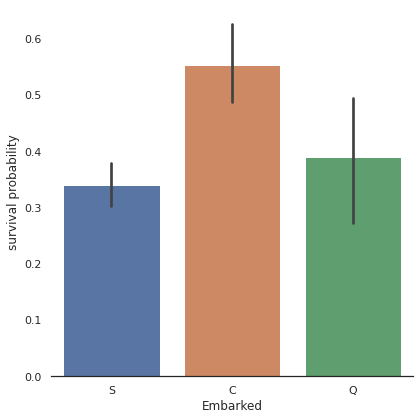

In [40]:
g = sns.catplot(x= "Embarked", y = "Survived", data = train, height=6, kind="bar")
g.despine(left=True)
g = g.set_ylabels("survival probability")

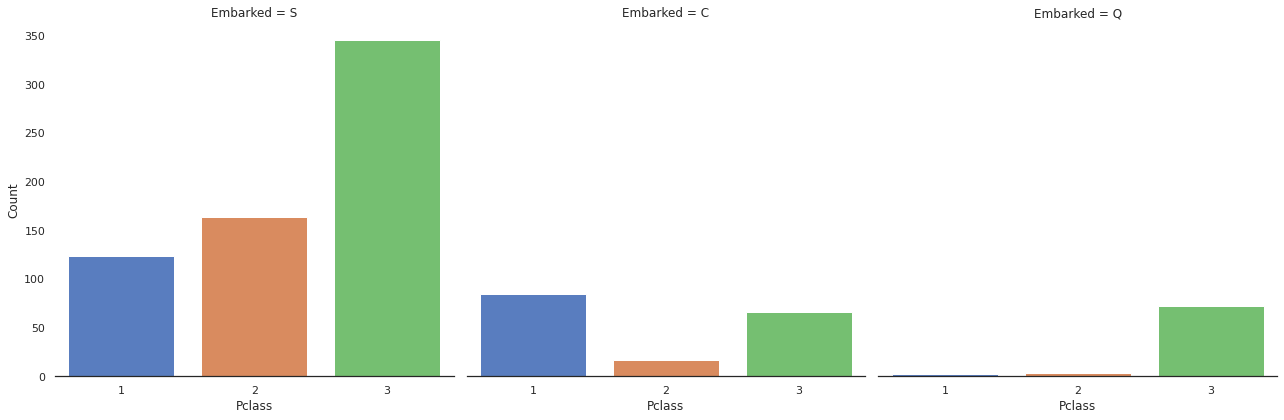

In [41]:
g = sns.catplot(x="Pclass", col="Embarked", data =train, height=6, kind="count", palette="muted")
g.despine(left = True)
g = g.set_ylabels("Count")

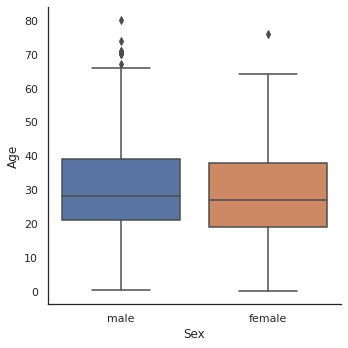

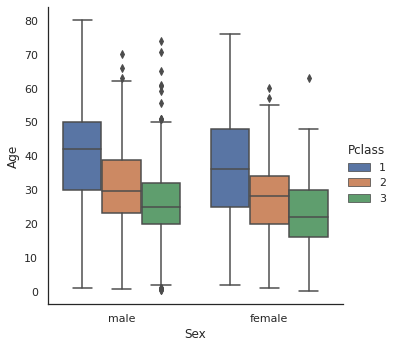

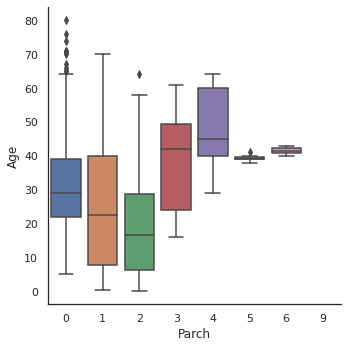

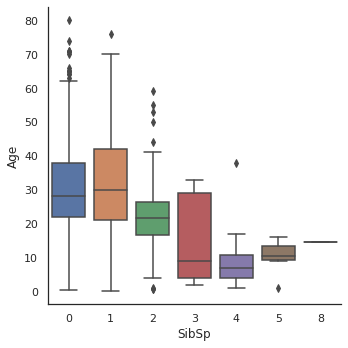

In [42]:
g = sns.catplot(y="Age", x= "Sex", data = dataset, kind="box")
g = sns.catplot(y="Age", x= "Sex", hue = "Pclass", data = dataset, kind="box")
g = sns.catplot(y="Age", x= "Parch", data = dataset, kind="box")
g = sns.catplot(y="Age", x= "SibSp", data = dataset, kind="box")

In [43]:
dataset["Sex"] = dataset["Sex"].map({"male" : 0, "female" : 1})

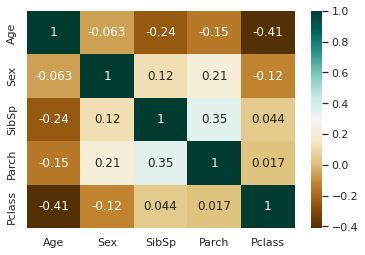

In [44]:
g = sns.heatmap(dataset[["Age", "Sex", "SibSp", "Parch", "Pclass"]].corr(), cmap="BrBG", annot=True)

In [46]:
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age:
  age_med = dataset["Age"].median()
  age_pred = dataset["Age"][(dataset["SibSp"] == dataset.iloc[i]["SibSp"])&
                            (dataset["Parch"] == dataset.iloc[i]["Parch"])&
                            (dataset["Pclass"] == dataset.iloc[i]["Pclass"])].median()

  if not np.isnan(age_pred): #안에 있는 수가 non이 아니면
    dataset["Age"].iloc[i] = age_pred
  else:
    dataset["Age"].iloc[i] = age_med

<ipython-input-46-2e2fb0cf53dc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["Age"].iloc[i] = age_pred
<ipython-input-46-2e2fb0cf53dc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["Age"].iloc[i] = age_pred
<ipython-input-46-2e2fb0cf53dc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["Age"].iloc[i] = age_pred
<ipython-input-46-2e2fb0cf53dc>:10: SettingWithCopyWarning: 
A value is trying to be set on

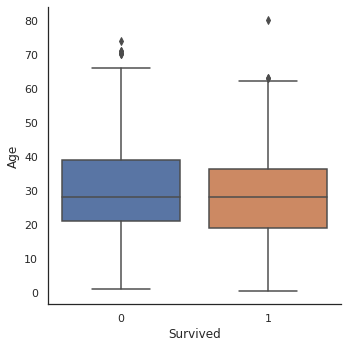

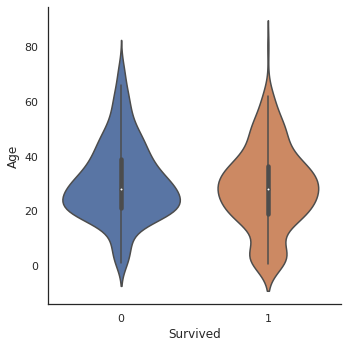

In [47]:
g = sns.catplot(x="Survived", y= "Age", data = train, kind="box")
g = sns.catplot(x="Survived", y= "Age", data = train, kind ="violin")


In [48]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [49]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

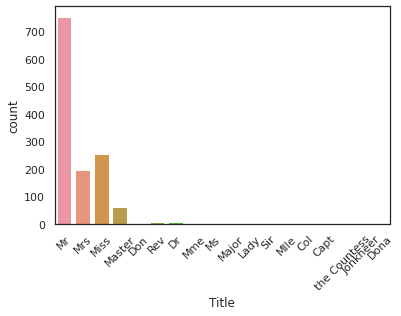

In [54]:
g = sns.countplot(x="Title", data =dataset)
#sept/rotation은 이름을 45도 회전.
g = plt.setp(g.get_xticklabels(), rotation=45)

In [62]:
dataset["Title"] = dataset["Title"].replace(["Lady", "the Countess", "Countess", "Capt", "Col", "Don", "Dr", 
                                             "Major", "Rev", "Sir", "Jonkheer", "Dona"], "Rare")
dataset["Title"] = dataset["Title"].map({"Master" : 0, "Miss" : 1, "Ms":1, "Mme":1, "Mile":1, "Mrs":1, "Mr":2, "Rare":3})

# dataset["Title"] = dataset["Title"].astype(int)

#어디서 꼬였는지 파악이 안되네...

In [63]:
dataset["Title"].isnull().sum()

1299

ValueError: ignored

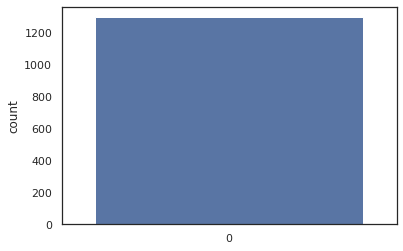

In [66]:
g = sns.countplot(dataset["Title"])
g =g.set_xticklabels(["Master", "Miss/Ms/Mme/Mile/Mrs", "Mr", "Rare","strange"])

ValueError: ignored

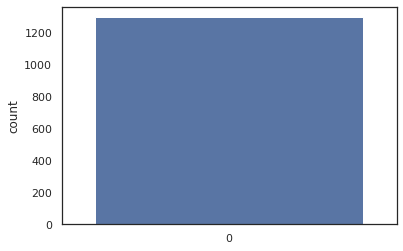

In [67]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

In [68]:
#오류가 나왔으여... 시간이 없ㅇ ㅓ해결은 흐흑...

In [69]:
dataset.drop(labels = ["Name"], axis= 1, inplace = True)

In [70]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] +1

/usr/local/lib/python3.9/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.9/dist-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist

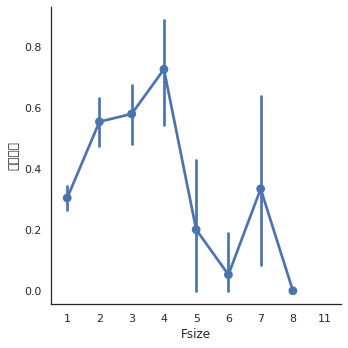

In [72]:
g = sns.catplot(x= "Fsize", y= "Survived", data = dataset, kind="point")
g = g.set_ylabels("생존확률")

In [73]:
dataset["Single"] = dataset["Fsize"].map(lambda s:1 if s==1 else 0)
dataset["SmallF"] = dataset["Fsize"].map(lambda s:1 if s==2 else 0)
dataset["MedF"] = dataset["Fsize"].map(lambda s:1 if 3<=s<=4 else 0)
dataset["LargeF"] = dataset["Fsize"].map(lambda s:1 if s>=5 else 0)

/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing f

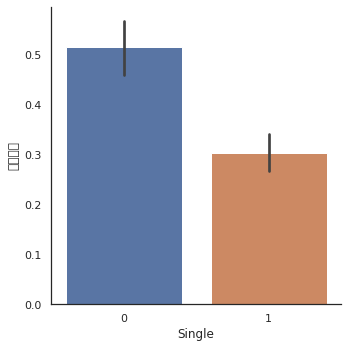

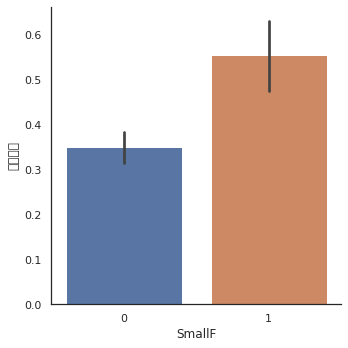

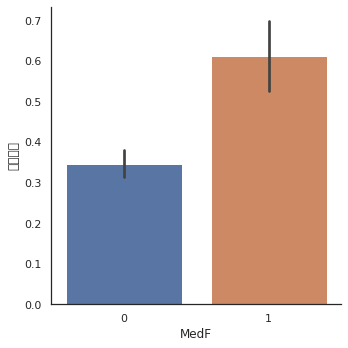

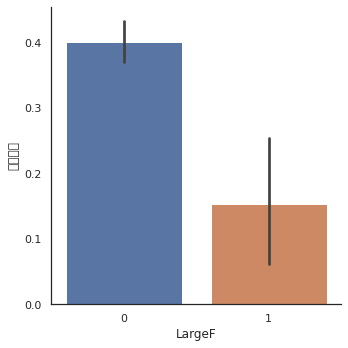

In [74]:
g = sns.catplot(x="Single", y="Survived", data=dataset, kind='bar')
g = g.set_ylabels("생존확률")

g = sns.catplot(x="SmallF", y="Survived", data=dataset, kind='bar')
g = g.set_ylabels("생존확률")

g = sns.catplot(x="MedF", y="Survived", data=dataset, kind='bar')
g = g.set_ylabels("생존확률")

g = sns.catplot(x="LargeF", y="Survived", data=dataset, kind='bar')
g = g.set_ylabels("생존확률")

In [82]:
dataset = pd.get_dummies(dataset, columns= ["Title"])
dataset = pd.get_dummies(dataset, columns= ["Embarked"], prefix = "Em")

#title, embark를 원핫인코딩하는거 -> 이걸 왜 하는거지..? 그 글을 숫자로 바꾸는거?

KeyError: ignored

In [83]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Fsize,Single,SmallF,MedF,LargeF,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,2,0,1,0,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,2,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,1,1,0,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,2,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,1,1,0,0,0,0,0,1


In [84]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [85]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [86]:
dataset["Cabin"].isnull().sum()

1007

In [87]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [91]:
# dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else "X" for i in dataset["Cabin"]])
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])


In [94]:
g = sns.countplot(dataset["Cabin"],order_by=['A','B','C','D','E','F','G','T','X'])
#입력값이 판다스여야하는데 뭦...?

ValueError: ignored

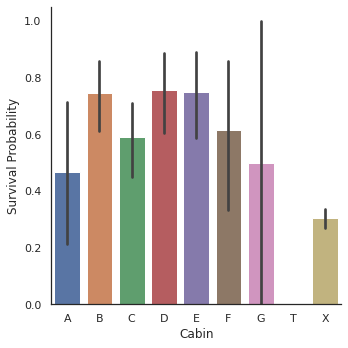

In [96]:
g = sns.catplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

In [97]:
dataset = pd.get_dummies(dataset, columns=["Cabin"],prefix = "Cabin")

In [98]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [99]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [100]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix = "T")

In [101]:
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"], prefix = "Pc")

In [102]:
dataset.drop(labels = ["PassengerId"], axis = 1, inplace=True)

In [103]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [104]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels = ["Survived"] ,axis = 1, inplace = True)

<ipython-input-104-f1a43f981d18>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(labels = ["Survived"] ,axis = 1, inplace = True)


In [105]:
train["Survived"] = train["Survived"].astype(int)
y_train = train["Survived"]
X_train = train.drop(labels = ["Survived"], axis = 1)

<ipython-input-105-4c5c89143875>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Survived"] = train["Survived"].astype(int)


In [106]:
k_fold = StratifiedKFold(n_splits = 10)

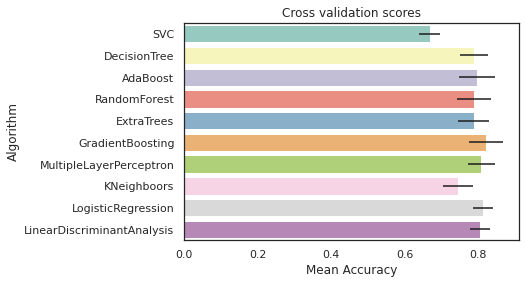

In [114]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
  #njobs : 코어수
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = k_fold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot(x = "CrossValMeans",y = "Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [117]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=k_fold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:905: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  clone(base_estimator).set_params(**self.best_params_)


In [118]:
gsadaDTC.best_score_

0.8218718079673136

In [119]:
ExtC = ExtraTreesClassifier()


ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=k_fold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,y_train)

ExtC_best = gsExtC.best_estimator_
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8048008171603677

In [120]:
RFC = RandomForestClassifier()


rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=k_fold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

gsRFC.best_score_


Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8172752808988765

In [122]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=k_fold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

gsGBC.best_score_


Fitting 10 folds for each of 72 candidates, totalling 720 fits


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


0.8149642492339122

In [123]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=k_fold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8308861082737489

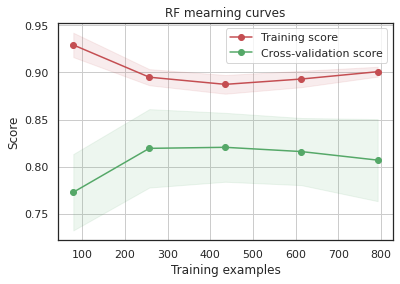

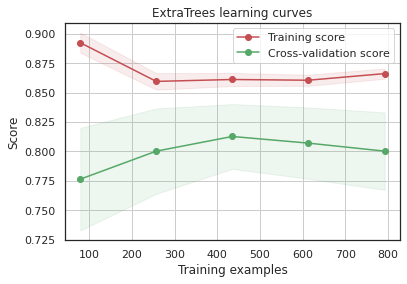

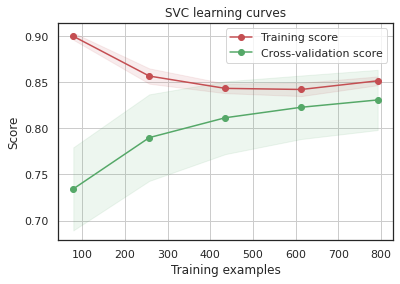

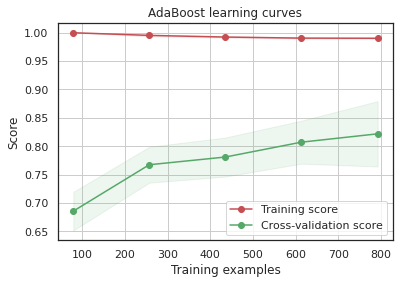

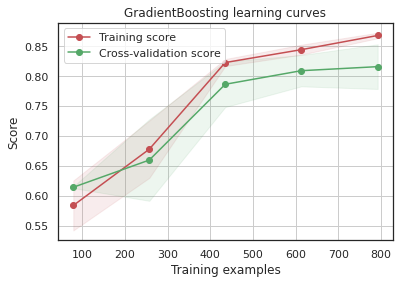

In [124]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,y_train,cv=k_fold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,y_train,cv=k_fold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,y_train,cv=k_fold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,y_train,cv=k_fold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,y_train,cv=k_fold)


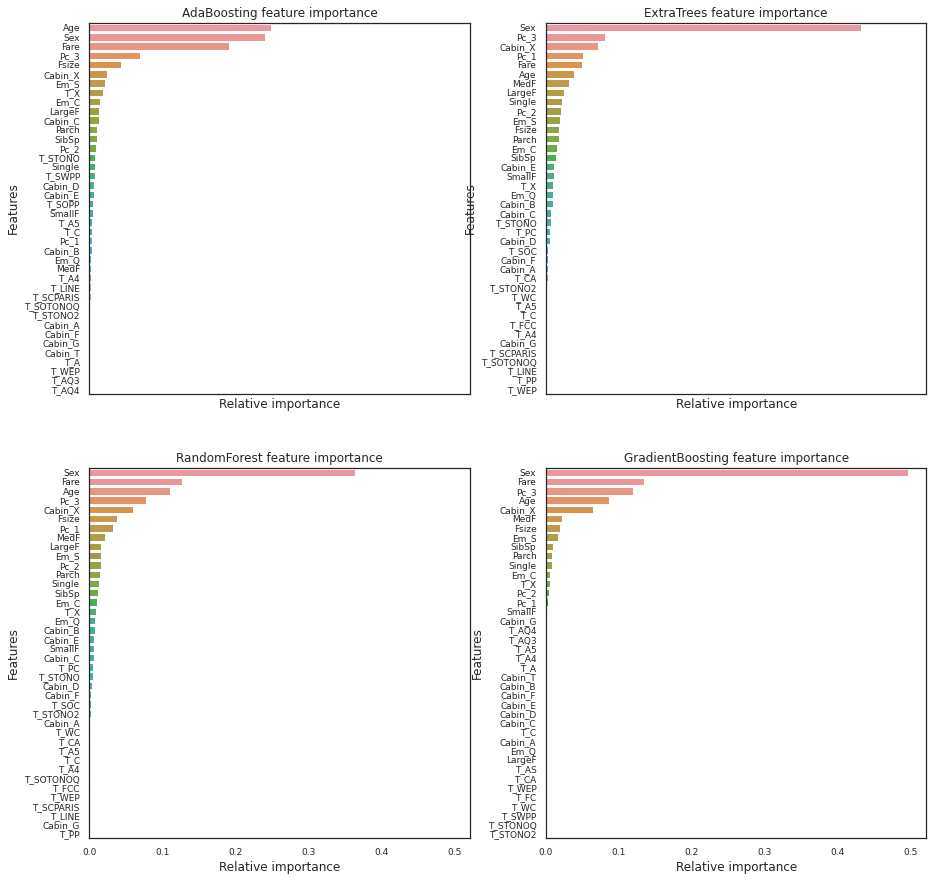

In [125]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

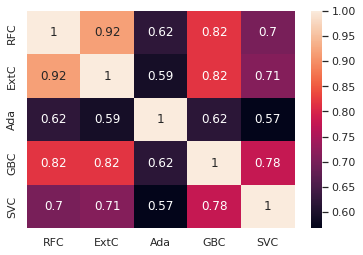

In [126]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [127]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, y_train)

In [128]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)